Fonte: https://basedosdados.org/dataset/f06f3cdc-b539-409b-b311-1ff8878fb8d9?table=a3696dc2-4dd1-4f7e-9769-6aa16a1556b8

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import sys
from pathlib import Path

notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

import locale
try:
    locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil')
except:
    pass

In [2]:
df = pl.read_parquet('../data/raw/queimadas_data-2015-2025.parquet')

print(f'\nDimensões: {df.height:,} linhas x {df.width} colunas')
print(f'Uso de memória: {df.estimated_size('mb'):.2f} MB')


Dimensões: 14,449,775 linhas x 13 colunas
Uso de memória: 1340.59 MB


Como os dados de 2025 estão incompletos, vamos removê-los.

In [3]:
df = df.filter(pl.col('ano') != 2025)
print(f'\nDimensões após filtro: {df.height:,} linhas x {df.width} colunas')


Dimensões após filtro: 14,371,675 linhas x 13 colunas


In [4]:
df.columns

['ano',
 'mes',
 'data_hora',
 'bioma',
 'sigla_uf',
 'id_municipio',
 'latitude',
 'longitude',
 'satelite',
 'dias_sem_chuva',
 'precipitacao',
 'risco_fogo',
 'potencia_radiativa_fogo']

In [5]:
df.schema

Schema([('ano', Int64),
        ('mes', Int64),
        ('data_hora', Datetime(time_unit='us', time_zone=None)),
        ('bioma', String),
        ('sigla_uf', String),
        ('id_municipio', String),
        ('latitude', Float64),
        ('longitude', Float64),
        ('satelite', String),
        ('dias_sem_chuva', Float64),
        ('precipitacao', Float64),
        ('risco_fogo', Float64),
        ('potencia_radiativa_fogo', Float64)])

## Verificação de valores nulos/indefinidos e duplicados
**Insight**: Nos anos de 2015 a 2022, as colunas 'satelite', 'dias_sem_chuva', 'precipitacao', 'risco_fogo' e 'potencia_radiativa_fogo' estão ausentes em sua totalidade. Elas estão presentes somente a partir de 2023. Dessa forma, podemos inferir que esses dados não eram coletados até então.

Isso nos coloca de frente com um problema: temos dois datasets e problemas de machine learning distintos. Um dataset possui dados espaço-temporais (2015 - 2022) e o outro possui dados espaço-temporais + dados meteorológicos (2023 - 2024). Diante de tal cenário, vamos remover as colunas que não possuem dados coletados durante o período de 2015 e 2022, a fim de manter a consistência do dataset e evitar a perda de um volume significativo de dados.

In [6]:
df.null_count()

ano,mes,data_hora,bioma,sigla_uf,id_municipio,latitude,longitude,satelite,dias_sem_chuva,precipitacao,risco_fogo,potencia_radiativa_fogo
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,6,0,0,0,0,1546643,1835488,1835488,1835488,2021982


In [7]:
df.is_duplicated().sum()

0

Vamos verificar a distribuição de valores nulos ao longo dos anos.

In [8]:
df_counts = (
    df.group_by('ano')
    .agg(pl.len().alias('qtd_registros'))
    .sort('ano')
    .with_columns([
        pl.col('qtd_registros').map_elements(
            lambda x: f'{x:_.0f}'.replace('_', '.'),
            return_dtype=pl.Utf8
        ).alias('qtd_registros_fmt'),
    ])
)

fig = px.bar(
    df_counts,
    x='ano',
    y='qtd_registros',
    title='Quantidade Total de Exemplos por Ano',
    labels={'ano': 'Ano', 'qtd_registros': 'Qtd. de registros'},
    text='qtd_registros_fmt',
    color='qtd_registros',
    custom_data=['qtd_registros_fmt'],
)

fig.update_traces(
    textposition='outside',
    cliponaxis=False,
    hovertemplate='Ano: %{x}<br>' +
                  'Qtd. de registros: %{customdata[0]}' +
                  '<extra></extra>',
)

fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},
)

fig.show()

In [9]:
df_nulls = (
    df.group_by('ano')
    .agg(pl.all().null_count())
    .sort('ano')
)

df_melted = (
    df_nulls.unpivot(
        index='ano',
        on=[col for col in df_nulls.columns if col != 'ano']
    )
    .filter(pl.col('value') > 0)
    .rename({'variable': 'feature', 'value': 'null_count'})
    .with_columns(
        pl.col('null_count').map_elements(
            lambda x: f'{x:_.0f}'.replace('_', '.'),
            return_dtype=pl.Utf8
        ).alias('null_count_fmt')
    )
)

df_plot = df_melted.to_pandas()

fig = go.Figure()

for feature in df_plot['feature'].unique():
    df_feature = df_plot[df_plot['feature'] == feature]
    fig.add_trace(go.Bar(
        name=feature,
        x=df_feature['ano'],
        y=df_feature['null_count'],
        text=df_feature['null_count_fmt'],
        textposition='inside',
        hovertemplate='<b>%{fullData.name}</b><br>Ano: %{x}<br>Nulls: %{text}<extra></extra>'
    ))

fig.update_layout(
    title='Valores Ausentes por Feature ao Longo dos Anos',
    xaxis=dict(title='Ano', tickmode='linear', dtick=1),
    yaxis=dict(title='Quantidade de Valores Ausentes', tickformat=','),
    barmode='stack',
    height=500,
    plot_bgcolor='white',
    hovermode='closest'
)

fig.show()

In [10]:
df = df.drop(['satelite', 'dias_sem_chuva', 'precipitacao', 'risco_fogo', 'potencia_radiativa_fogo'])

In [11]:
# Remoção dos registros com bioma indefinido
df = df.filter(pl.col('bioma').is_not_null())

Como já temos a latitude, longitude e estado, podemos remover a coluna 'id_municipio'.

In [12]:
df = df.drop(['id_municipio'])
print(f'\nDimensões do dataset após remoção de features: {df.height:,} linhas x {df.width} colunas')


Dimensões do dataset após remoção de features: 14,371,669 linhas x 7 colunas


In [13]:
df.columns

['ano', 'mes', 'data_hora', 'bioma', 'sigla_uf', 'latitude', 'longitude']

Refaçamos a verificação de valores nulos e duplicados para o dataset.

**Insight**: Podemos ver que não há valores nulos ou duplicados no dataset, o que é esperado já que a fonte afirma que os dados foram previamente tratados.

In [14]:
df.null_count()

ano,mes,data_hora,bioma,sigla_uf,latitude,longitude
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


In [15]:
df.is_duplicated().sum()

114

Também sabemos da fonte que pode haver múltiplos registros de focos de queimadas em um mesmo dia e local, mas em horários diferentes. Contudo, esse nível de granularidade não é necessário para a análise que pretendemos fazer. Desse modo, vamos agrupar esses registros, a princípio, a nível de dia.

In [16]:
# Remoção de duplicatas exatas para um mesmo ponto no espaço e tempo
df = df.unique(keep='first')

# Registros duplicados a nível de dia
df = df.with_columns([
    (pl.col('latitude').cast(pl.Utf8) + '_' +
     pl.col('longitude').cast(pl.Utf8) + '_' +
     pl.col('data_hora').dt.truncate('1d').cast(pl.Utf8)).alias('st_key')
])
day_duplicates = df.filter(pl.col('st_key').is_duplicated()).height
print(f'Duplicatas a nível de dia: {day_duplicates:,} ({day_duplicates/df.height*100:.2f}%)')

Duplicatas a nível de dia: 2,863,371 (19.92%)


In [17]:
df.sort('st_key').head()

ano,mes,data_hora,bioma,sigla_uf,latitude,longitude,st_key
i64,i64,datetime[μs],str,str,f64,f64,str
2024,2,2024-02-20 04:59:00,"""Amazônia""","""RR""",-0.00002,-60.58794,"""-0.00002_-60.58794_2024-02-20 …"
2024,11,2024-11-02 16:52:00,"""Amazônia""","""PA""",-0.00003,-50.00152,"""-0.00003_-50.00152_2024-11-02 …"
2023,10,2023-10-09 16:39:00,"""Amazônia""","""AP""",-0.00006,-51.6736,"""-0.00006_-51.6736_2023-10-09 0…"
2024,2,2024-02-20 18:08:00,"""Amazônia""","""RR""",-0.00008,-60.59319,"""-0.00008_-60.59319_2024-02-20 …"
2023,11,2023-11-05 17:24:00,"""Amazônia""","""AP""",-0.00011,-51.13868,"""-0.00011_-51.13868_2023-11-05 …"


### Feature Engineering e agrupamento de registros por dia

In [18]:
df = df.with_columns([
    pl.col('data_hora').dt.hour().cast(pl.Int8).alias('hora'),
    pl.col('data_hora').dt.weekday().cast(pl.Int8).alias('dia_semana'),
    pl.col('data_hora').dt.ordinal_day().cast(pl.Int16).alias('dia_ano'),
    ((pl.col('data_hora').dt.ordinal_day() - 1) // 7 + 1).cast(pl.Int8).alias('semana_ano'),
    pl.col('data_hora').dt.quarter().cast(pl.Int8).alias('trimestre'),
])

# Definição do período do dia
df = df.with_columns([
    pl.when(pl.col('hora') < 6).then(pl.lit('Madrugada'))
      .when(pl.col('hora') < 12).then(pl.lit('Manhã'))
      .when(pl.col('hora') < 18).then(pl.lit('Tarde'))
      .otherwise(pl.lit('Noite'))
      .cast(pl.Categorical)
      .alias('periodo_dia')
])

# Definição da estação do ano (Brasil)
df = df.with_columns([
    pl.when(pl.col('mes').is_in([12, 1, 2])).then(pl.lit('Verão'))
      .when(pl.col('mes').is_in([3, 4, 5])).then(pl.lit('Outono'))
      .when(pl.col('mes').is_in([6, 7, 8])).then(pl.lit('Inverno'))
      .otherwise(pl.lit('Primavera'))
      .cast(pl.Categorical)
      .alias('estacao_ano')
])

# Definição do período climático com base no bioma e mês
df = df.with_columns([
    pl.when((pl.col('bioma') == 'Amazônia') & pl.col('mes').is_in([6, 7, 8, 9, 10, 11]))
      .then(pl.lit('Seco'))
      .when((pl.col('bioma') == 'Cerrado') & pl.col('mes').is_in([5, 6, 7, 8, 9]))
      .then(pl.lit('Seco'))
      .when((pl.col('bioma') == 'Caatinga') & pl.col('mes').is_in([6, 7, 8, 9, 10, 11, 12]))
      .then(pl.lit('Seco'))
      .otherwise(pl.lit('Chuvoso'))
      .cast(pl.Categorical)
      .alias('periodo_climatico')
])

In [19]:
df = df.with_columns([
    pl.col('data_hora').dt.date().alias('data_dia')
])

GROUP_COLS = ['latitude', 'longitude', 'data_dia', 'bioma', 'sigla_uf']

# Agrega com base em critérios específicos e renomeia cada feature
df_daily = df.group_by(GROUP_COLS).agg([
    pl.col('ano').first().alias('ano'),
    pl.col('mes').first().alias('mes'),
    pl.col('dia_ano').first().alias('dia_ano'),
    pl.col('dia_semana').first().alias('dia_semana'),
    pl.col('semana_ano').first().alias('semana_ano'),
    pl.col('trimestre').first().alias('trimestre'),

    pl.col('periodo_dia').mode().first().alias('periodo_dia_predominante'),
    pl.col('estacao_ano').first().alias('estacao_ano'),
    pl.col('periodo_climatico').first().alias('periodo_climatico'),

    pl.col('hora').min().alias('hora_primeira_deteccao'),
    pl.col('hora').max().alias('hora_ultima_deteccao'),

    pl.len().alias('num_deteccoes_dia'),
])

df_daily = df_daily.with_columns([
    (pl.col('num_deteccoes_dia') > 1).cast(pl.Int8).alias('multiplas_deteccoes'),
])

# Converte as variáveis categóricas
CAT_VARS = [
    'mes', 'dia_ano', 'dia_semana', 'semana_ano', 'trimestre',
    'periodo_dia_predominante', 'estacao_ano', 'periodo_climatico',
    'bioma', 'sigla_uf'
]
with pl.StringCache():
    df_daily = df_daily.with_columns([
        pl.col(c).cast(pl.Utf8).cast(pl.Categorical)
        for c in CAT_VARS if c in df_daily.columns
    ])

In [20]:
print(f'\nDimensões do dataset diário: {df_daily.height:,} linhas x {df_daily.width} colunas')


Dimensões do dataset diário: 11,912,771 linhas x 18 colunas


In [21]:
df_daily.head()

latitude,longitude,data_dia,bioma,sigla_uf,ano,mes,dia_ano,dia_semana,semana_ano,trimestre,periodo_dia_predominante,estacao_ano,periodo_climatico,hora_primeira_deteccao,hora_ultima_deteccao,num_deteccoes_dia,multiplas_deteccoes
f64,f64,date,cat,cat,i64,cat,cat,cat,cat,cat,cat,cat,cat,i8,i8,u32,i8
-3.8732,-52.092,2024-10-02,"""Amazônia""","""PA""",2024,"""10""","""276""","""3""","""40""","""4""","""Noite""","""Primavera""","""Seco""",22,22,1,0
-7.39647,-64.36403,2024-08-17,"""Amazônia""","""AM""",2024,"""8""","""230""","""6""","""33""","""3""","""Noite""","""Inverno""","""Seco""",18,18,1,0
-9.525,-50.159,2020-09-29,"""Amazônia""","""PA""",2020,"""9""","""273""","""2""","""39""","""3""","""Tarde""","""Primavera""","""Seco""",16,16,1,0
-9.7409,-36.1314,2024-02-07,"""Mata Atlântica""","""AL""",2024,"""2""","""38""","""3""","""6""","""1""","""Madrugada""","""Verão""","""Chuvoso""",0,0,1,0
2.13647,-50.91278,2024-10-02,"""Amazônia""","""AP""",2024,"""10""","""276""","""3""","""40""","""4""","""Madrugada""","""Primavera""","""Seco""",5,5,1,0


## Visualizações
TODO

## Análise univariada

In [22]:
out = {}

CATEGORICAL_COLS = [
    'bioma', 'sigla_uf', 'mes', 'dia_ano', 'dia_semana', 'semana_ano', 'trimestre',
    'periodo_dia_predominante', 'estacao_ano', 'periodo_climatico'
]

NUMERIC_COLS = [
    'latitude', 'longitude',
    'hora_primeira_deteccao', 'hora_ultima_deteccao',
    'num_deteccoes_dia', 'multiplas_deteccoes'
]

DATE_COLS = ['data_dia']

ORDINAL_TIME_COLS = ['ano']

### Features numéricas
**Insight**: No geral, as variáveis numéricas possuem distribuições diferentes entre si e assimétricas. As que possuem suas distribuições mais concentradas são 'num_deteccoes_dia' e 'multiplas_deteccoes', enquanto a primeira é a que possui a maior quantidade outliers.

In [23]:
numerical_stats = df_daily.select(NUMERIC_COLS).describe()
out['numerical_stats'] = numerical_stats
numerical_stats

statistic,latitude,longitude,hora_primeira_deteccao,hora_ultima_deteccao,num_deteccoes_dia,multiplas_deteccoes
str,f64,f64,f64,f64,f64,f64
"""count""",1.1912771e7,1.1912771e7,1.1912771e7,1.1912771e7,1.1912771e7,1.1912771e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-9.743444,-52.476791,12.434521,12.533247,1.206404,0.033958
"""std""",6.019355,7.318032,6.165923,6.181432,1.895186,0.18112
"""min""",-33.74046,-73.86338,0.0,0.0,1.0,0.0
"""25%""",-13.1973,-57.37216,5.0,5.0,1.0,0.0
"""50%""",-8.95198,-52.08099,16.0,16.0,1.0,0.0
"""75%""",-5.95782,-46.76574,17.0,17.0,1.0,0.0
"""max""",5.21761,-34.79613,23.0,23.0,130.0,1.0


In [24]:
def col_stats(c: str) -> pl.DataFrame:
    x = pl.col(c).drop_nulls().cast(pl.Float64)
    return df_daily.select(
        pl.lit(c).alias('variavel'),
        x.quantile(0.25).alias('q1'),
        x.median().alias('median'),
        x.quantile(0.75).alias('q3'),
    )

In [25]:
# Por razões de performance, amostrar somente uma quantidade
# limitada de outliers e pontos por variável
MAX_OUTLIERS_PER_VAR = 3000

stats = (
    pl.concat([col_stats(c) for c in NUMERIC_COLS], how='vertical')
    .with_columns([
        (pl.col('q3') - pl.col('q1')).alias('iqr'),
        (pl.col('q1') - 1.5 * (pl.col('q3') - pl.col('q1'))).alias('lowerfence'),
        (pl.col('q3') + 1.5 * (pl.col('q3') - pl.col('q1'))).alias('upperfence'),
    ])
    .select(['variavel', 'q1', 'median', 'q3', 'lowerfence', 'upperfence'])
)

s = stats.to_dict(as_series=False)

outliers_long = (
    df_daily
    .select(NUMERIC_COLS)
    .unpivot(variable_name='variavel', value_name='valor')
    .drop_nulls('valor')
    .with_columns(pl.col('valor').cast(pl.Float64))
    .join(stats.select(['variavel', 'lowerfence', 'upperfence']), on='variavel', how='inner')
    .filter((pl.col('valor') < pl.col('lowerfence')) | (pl.col('valor') > pl.col('upperfence')))
    # Pega os outliers mais distantes das cercas
    .with_columns(
        pl.when(pl.col('valor') < pl.col('lowerfence'))
          .then(pl.col('lowerfence') - pl.col('valor'))
          .otherwise(pl.col('valor') - pl.col('upperfence'))
          .alias('dist_fence')
    )
    .sort(['variavel', 'dist_fence'], descending=[False, True])
    .group_by('variavel', maintain_order=True)
    .head(MAX_OUTLIERS_PER_VAR)
    .select(['variavel', 'valor'])
)

o = outliers_long.to_dict(as_series=False)

fig = go.Figure()

fig.add_trace(go.Box(
    x=s['variavel'],
    q1=s['q1'],
    median=s['median'],
    q3=s['q3'],
    lowerfence=s['lowerfence'],
    upperfence=s['upperfence'],
    boxpoints=False,
    name='Distribuição'
))

fig.add_trace(go.Scatter(
    x=o['variavel'],
    y=o['valor'],
    mode='markers',
    name=f'Outliers (amostrados)',
    marker=dict(size=4, opacity=0.55),
))

fig.update_layout(
    title='Distribuição das Variáveis Numéricas',
    xaxis_title='Variável',
    yaxis_title='Valor',
)
fig.show()

### Features categóricas
Amazônia (51,7%). PA (22%) e MT (17,6%). Meses de agosto (22,4%) e setembro (29,6%). Sem diferenças significativas entre dias do ano e da semana e semana do ano (isoladamente). 3º trimestre (58%). Tarde (58,5%). Primavera (56,2%). Seco (74,5%).

**Insights**:
- A Amazônia é o bioma com maior número de focos de queimadas, representando 51,7% dos registros.
- Os estados do PA (22%) e MT (17,6%) são os que mais apresentam focos de queimadas.
- Os meses de agosto (22,4%) e setembro (29,6%) concentram a maioria dos registros.
- O 3º trimestre do ano (58%) é o período com mais focos de queimadas.
- A maioria dos focos de queimadas ocorre à tarde (58,5%).
- A primavera (56,2%) é a estação do ano com mais registros de queimadas.
- O período seco (74,5%) é o que apresenta a maior quantidade de focos de queimadas.

In [26]:
cat_summaries = {}
for col in CATEGORICAL_COLS:
    var_count = (
        df_daily
        .group_by(col)
        .len()
        .sort('len', descending=True)
        .rename({'len': 'count'})
    )
    var_count = var_count.with_columns((pl.col('count') / df_daily.height).alias('pct'))
    cat_summaries[col] = var_count

out['categorical_summaries'] = cat_summaries
cat_summaries

{'bioma': shape: (6, 3)
 ┌────────────────┬─────────┬──────────┐
 │ bioma          ┆ count   ┆ pct      │
 │ ---            ┆ ---     ┆ ---      │
 │ cat            ┆ u32     ┆ f64      │
 ╞════════════════╪═════════╪══════════╡
 │ Amazônia       ┆ 6159984 ┆ 0.517091 │
 │ Cerrado        ┆ 3508035 ┆ 0.294477 │
 │ Caatinga       ┆ 798419  ┆ 0.067022 │
 │ Mata Atlântica ┆ 713111  ┆ 0.059861 │
 │ Pantanal       ┆ 707772  ┆ 0.059413 │
 │ Pampa          ┆ 25450   ┆ 0.002136 │
 └────────────────┴─────────┴──────────┘,
 'sigla_uf': shape: (27, 3)
 ┌──────────┬─────────┬──────────┐
 │ sigla_uf ┆ count   ┆ pct      │
 │ ---      ┆ ---     ┆ ---      │
 │ cat      ┆ u32     ┆ f64      │
 ╞══════════╪═════════╪══════════╡
 │ PA       ┆ 2620508 ┆ 0.219975 │
 │ MT       ┆ 2096863 ┆ 0.176018 │
 │ MA       ┆ 1080327 ┆ 0.090686 │
 │ AM       ┆ 1012493 ┆ 0.084992 │
 │ TO       ┆ 743438  ┆ 0.062407 │
 │ …        ┆ …       ┆ …        │
 │ RN       ┆ 30780   ┆ 0.002584 │
 │ ES       ┆ 29392   ┆ 0.002467 │


A seguir, fazemos uma análise das variáveis categóricas de tempo.

In [27]:
out['freq_by_year'] = df_daily.group_by('ano').len().sort('ano').rename({'len': 'count'})
out['freq_by_month'] = df_daily.group_by('mes').len().sort('mes').rename({'len': 'count'})
out['freq_by_weekday'] = df_daily.group_by('dia_semana').len().sort('dia_semana').rename({'len': 'count'})

In [28]:
out

{'numerical_stats': shape: (9, 7)
 ┌────────────┬─────────────┬─────────────┬──────────────┬──────────────┬─────────────┬─────────────┐
 │ statistic  ┆ latitude    ┆ longitude   ┆ hora_primeir ┆ hora_ultima_ ┆ num_detecco ┆ multiplas_d │
 │ ---        ┆ ---         ┆ ---         ┆ a_deteccao   ┆ deteccao     ┆ es_dia      ┆ eteccoes    │
 │ str        ┆ f64         ┆ f64         ┆ ---          ┆ ---          ┆ ---         ┆ ---         │
 │            ┆             ┆             ┆ f64          ┆ f64          ┆ f64         ┆ f64         │
 ╞════════════╪═════════════╪═════════════╪══════════════╪══════════════╪═════════════╪═════════════╡
 │ count      ┆ 1.1912771e7 ┆ 1.1912771e7 ┆ 1.1912771e7  ┆ 1.1912771e7  ┆ 1.1912771e7 ┆ 1.1912771e7 │
 │ null_count ┆ 0.0         ┆ 0.0         ┆ 0.0          ┆ 0.0          ┆ 0.0         ┆ 0.0         │
 │ mean       ┆ -9.743444   ┆ -52.476791  ┆ 12.434521    ┆ 12.533247    ┆ 1.206404    ┆ 0.033958    │
 │ std        ┆ 6.019355    ┆ 7.318032    ┆ 6.16

## Análise de correlação
**Insight**: No geral, as features numéricas possuem correlações fracas entre si. Contudo, as que merecem destaque são: 'hora_primeira_deteccao' e 'hora_ultima_deteccao' (0,99) e 'num_deteccoes_dia' e 'multiplas_deteccoes' (0,58).

A análise de correlação das variáveis categóricas mostrou muitos relacionamentos "óbvios", como mês com trimestre ou dia do ano com semana do ano.

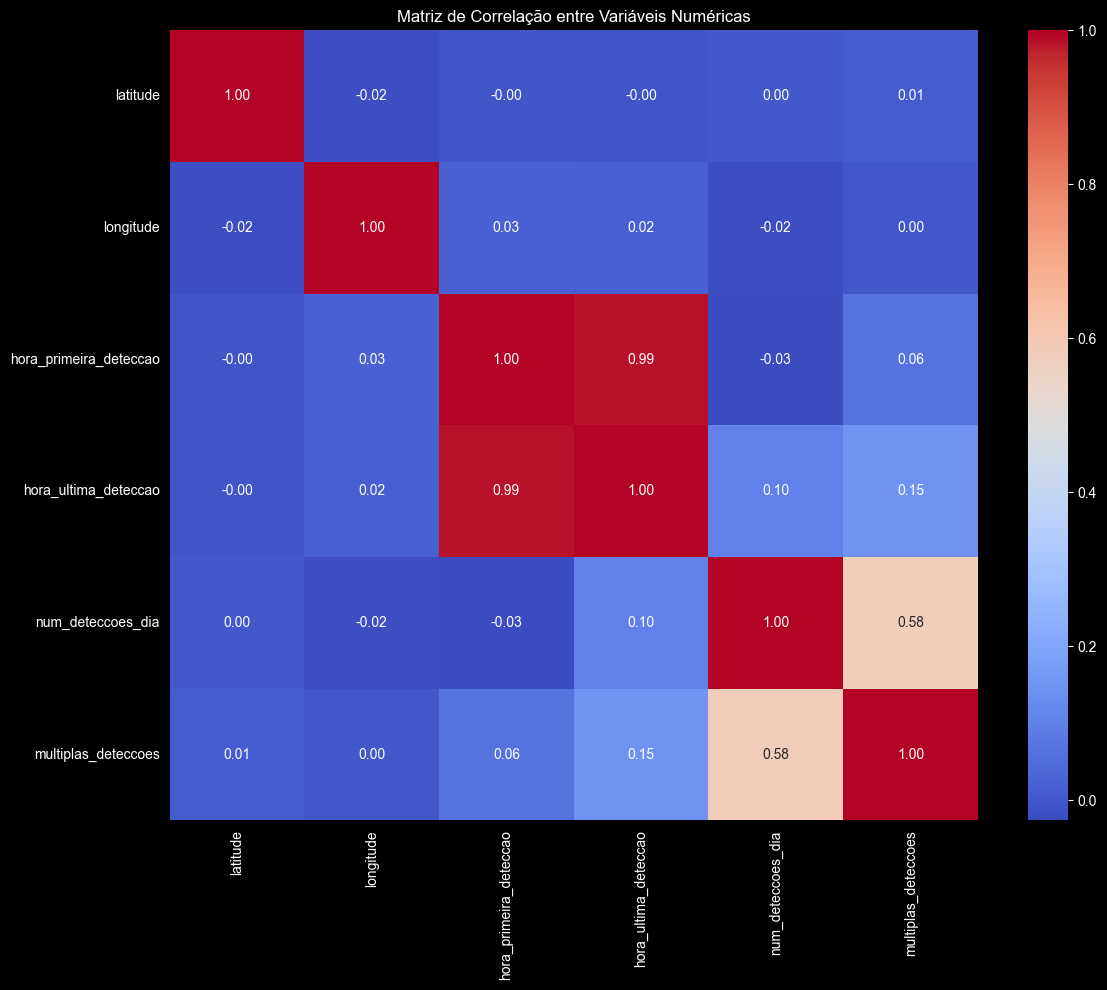

In [34]:
corr_pd = df_daily.select(NUMERIC_COLS).to_pandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_pd, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

Para a análise de correlação entre variáveis categóricas, utilizamos o V de Cramer, computado como:
$$
V = \sqrt{\frac{\mathrm{χ}^2}{n \times \min(k - 1, r - 1)}},
$$
Onde:
- $\mathrm{χ}^2$ é o valor do teste qui-quadrado;
- $n$ é o número de elementos incluídos na tabela;
- $k$ é o número de colunas;
- $r$ é o número de linhas.

Quanto mais próximo V é de 0, menor é a associação entre as variáveis analisadas.

In [30]:
from scripts.cramers import Cramers
import itertools

In [31]:
cat_corr = []
for x1, x2 in itertools.combinations(CATEGORICAL_COLS, 2):
    v = Cramers(df_daily, x1, x2).compute_v()
    cat_corr.append({
        'var1': x1,
        'var2': x2,
        'cramers_v': v,
    })

cat_corr_df = pl.DataFrame(cat_corr).sort('cramers_v', descending=True)
cat_corr_df

var1,var2,cramers_v
str,str,f64
"""mes""","""trimestre""",1.0
"""mes""","""estacao_ano""",1.0
"""dia_ano""","""semana_ano""",1.0
"""dia_ano""","""trimestre""",0.997747
"""semana_ano""","""trimestre""",0.995848
…,…,…
"""dia_semana""","""periodo_climatico""",0.030802
"""dia_semana""","""estacao_ano""",0.026023
"""dia_semana""","""trimestre""",0.024364


## Análise de sazonalidade

In [32]:
out_season = {}

df_m = df_daily.with_columns([
    pl.col('data_dia').dt.truncate('1mo').alias('mes_inicio'),
    pl.col('data_dia').dt.year().alias('ano_mes_year'),
    pl.col('data_dia').dt.month().alias('ano_mes_month'),
]).with_columns([
    (pl.col('ano_mes_year').cast(pl.Utf8) + "-" + pl.col('ano_mes_month').cast(pl.Utf8).str.zfill(2)).alias('ano_mes')
])

# Média por mês ao longo dos anos
monthly = (
    df_m.group_by(['mes_inicio', 'ano_mes_year', 'ano_mes_month', 'ano_mes'])
        .agg([
            pl.len().alias('n_dias_com_evento'),
            pl.col('num_deteccoes_dia').sum().alias('total_deteccoes_mes'),
            pl.col('num_deteccoes_dia').mean().alias('media_deteccoes_por_dia'),
            pl.col('num_deteccoes_dia').median().alias('mediana_deteccoes_por_dia'),
            pl.col('multiplas_deteccoes').mean().alias('pct_multiplas_deteccoes'),
            pl.n_unique('latitude').alias('n_lat_distintas'),
            pl.n_unique('longitude').alias('n_lon_distintas'),
        ])
        .sort('mes_inicio')
)
out_season['monthly_summary'] = monthly

# Média por mês do ano e bioma ao longo dos anos
monthly_by_bioma = (
    df_m.group_by(['bioma', 'mes_inicio', 'ano_mes_year', 'ano_mes_month'])
        .agg([
            pl.len().alias('n_dias_com_evento'),
            pl.col('num_deteccoes_dia').sum().alias('total_deteccoes_mes'),
            pl.col('num_deteccoes_dia').mean().alias('media_deteccoes_por_dia'),
            pl.col('multiplas_deteccoes').mean().alias('pct_multiplas_deteccoes'),
        ])
        .sort(['bioma', 'mes_inicio'])
)
out_season['monthly_by_bioma_summary'] = monthly_by_bioma

# Média por mês do ano ao longo dos anos
climatology = (
    monthly.group_by('ano_mes_month')
           .agg([
               pl.col('n_dias_com_evento').mean().alias('mean_n_dias_com_evento'),
               pl.col('total_deteccoes_mes').mean().alias('mean_total_deteccoes_mes'),
               pl.col('media_deteccoes_por_dia').mean().alias('mean_media_deteccoes_dia'),
               pl.col('pct_multiplas_deteccoes').mean().alias('mean_pct_multiplas'),
           ])
           .sort('ano_mes_month')
           .rename({'ano_mes_month': 'mes_num'})
)
out_season['climatology_summary'] = climatology

# Média por mês do ano e bioma ao longo dos anos
climatology_bioma = (
    out_season['monthly_by_bioma_summary']
      .group_by(['bioma', 'ano_mes_month'])
      .agg([
          pl.col('n_dias_com_evento').mean().alias('mean_n_dias_com_evento'),
          pl.col('total_deteccoes_mes').mean().alias('mean_total_deteccoes_mes'),
          pl.col('media_deteccoes_por_dia').mean().alias('mean_media_deteccoes_dia'),
          pl.col('pct_multiplas_deteccoes').mean().alias('mean_pct_multiplas'),
      ])
      .sort(['bioma', 'ano_mes_month'])
      .rename({'ano_mes_month': 'mes_num'})
)
out_season['climatology_by_bioma_summary'] = climatology_bioma

In [33]:
out_season

{'monthly_summary': shape: (120, 11)
 ┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ mes_inicio ┆ ano_mes_y ┆ ano_mes_m ┆ ano_mes ┆ … ┆ mediana_d ┆ pct_multi ┆ n_lat_dis ┆ n_lon_dis │
 │ ---        ┆ ear       ┆ onth      ┆ ---     ┆   ┆ eteccoes_ ┆ plas_dete ┆ tintas    ┆ tintas    │
 │ date       ┆ ---       ┆ ---       ┆ str     ┆   ┆ por_dia   ┆ ccoes     ┆ ---       ┆ ---       │
 │            ┆ i32       ┆ i8        ┆         ┆   ┆ ---       ┆ ---       ┆ u32       ┆ u32       │
 │            ┆           ┆           ┆         ┆   ┆ f64       ┆ f64       ┆           ┆           │
 ╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 2015-01-01 ┆ 2015      ┆ 1         ┆ 2015-01 ┆ … ┆ 1.0       ┆ 0.0       ┆ 3813      ┆ 3920      │
 │ 2015-02-01 ┆ 2015      ┆ 2         ┆ 2015-02 ┆ … ┆ 1.0       ┆ 0.0       ┆ 1888      ┆ 1873      │
 │ 2015-03-01 ┆ 2015      ┆ 3         ┆ 2015-

In [37]:
monthly.head()

mes_inicio,ano_mes_year,ano_mes_month,ano_mes,n_dias_com_evento,total_deteccoes_mes,media_deteccoes_por_dia,mediana_deteccoes_por_dia,pct_multiplas_deteccoes,n_lat_distintas,n_lon_distintas
date,i32,i8,str,u32,u32,f64,f64,f64,u32,u32
2015-01-01,2015,1,"""2015-01""",4313,4313,1.0,1.0,0.0,3813,3920
2015-02-01,2015,2,"""2015-02""",2026,2026,1.0,1.0,0.0,1888,1873
2015-03-01,2015,3,"""2015-03""",1659,1659,1.0,1.0,0.0,1565,1589
2015-04-01,2015,4,"""2015-04""",2024,2024,1.0,1.0,0.0,1890,1911
2015-05-01,2015,5,"""2015-05""",2169,2169,1.0,1.0,0.0,1990,1986


## Exportação de datasets finais

In [35]:
df_daily.write_parquet('../data/processed/queimadas_daily-2015-2024.parquet', compression='snappy')

In [38]:
monthly.write_parquet('../data/processed/queimadas_monthly-2015-2024.parquet', compression='snappy')
monthly_by_bioma.write_parquet('../data/processed/queimadas_monthly_by_bioma-2015-2024.parquet', compression='snappy')
climatology.write_parquet('../data/processed/queimadas_climatology-2015-2024.parquet', compression='snappy')
climatology_bioma.write_parquet('../data/processed/queimadas_climatology_by_bioma-2015-2024.parquet', compression='snappy')